# Predicting Whether a Breast Cancer Sample is Benign or Malignant

## Learning Objectives:


1. Understand what SageMaker Script Mode is, and how it can be leveraged.
2. Read in data from S3 to SageMaker
3. User prebuilt SageMaker containers to build, train, and deploy customer sklearn model
4. Use batch transform to perform inferences and measure model performance.


## Introduction
This is a breast cancer diagnoses dataset, where, for each sample, the sample is diagnosed as "Benign" or "Malignant". For each sample, a number of features are given as well. The source of the dataset is the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

For this model, we will build, train and deploy a [Multi-layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) using the sklearn library.



## Setup

In [3]:
# Ensure we have the right version of sagemaker
%pip install sagemaker==2.48.0

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached sagemaker-2.48.0-py2.py3-none-any.whl
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.70.0
    Uninstalling sagemaker-2.70.0:
      Successfully uninstalled sagemaker-2.70.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import required libraries and create necessary clients
import boto3
import matplotlib.pyplot as plt
import pandas
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.s3 import S3Downloader, S3Uploader
import sklearn
import sklearn.metrics as metrics
from sklearn import model_selection
import s3fs

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX = "breast_cancer"

## Process the Data

In [37]:
# Download the sample data
S3Downloader.download(
    s3_uri="s3://sagemaker-sample-files/datasets/tabular/breast_cancer/wdbc.csv",
    local_path="data",
    sagemaker_session=sagemaker_session,
)

df_data = pandas.read_csv(
    "data/wdbc.csv",
    names=[
        "id",
        "diagnosis",
        "radius_mean",
        "texture_mean",
        "perimeter_mean",
        "area_mean",
        "smoothness_mean",
        "compactness_mean",
        "concavity_mean",
        "concave points_mean",
        "symmetry_mean",
        "fractal_dimension_mean",
        "radius_se",
        "texture_se",
        "perimeter_se",
        "area_se",
        "smoothness_se",
        "compactness_se",
        "concavity_se",
        "concave points_se",
        "symmetry_se",
        "fractal_dimension_se",
        "radius_worst",
        "texture_worst",
        "perimeter_worst",
        "area_worst",
        "smoothness_worst",
        "compactness_worst",
        "concavity_worst",
        "concave points_worst",
        "symmetry_worst",
        "fractal_dimension_worst",
    ],
)
df_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [38]:
df_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [26]:
print(df_data.columns)
print(len(df_data.columns))

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
32


In [27]:
# Get the feature names for analysis
features = list(set(df_data.columns) - set(["id", "diagnosis"]))
# One-hot encode the diagnosis column
df_data = pandas.get_dummies(df_data, columns=["diagnosis"])
# Get the data with encoded features. Malignant is now 1, Benign is 0
df_data = df_data.rename(columns={"diagnosis_M": "truth"})
df_data = df_data[features + ["truth"]]

In [32]:
df_data.head(20)

,smoothness_worst,texture_worst,radius_se,compactness_worst,concavity_worst,radius_mean,area_mean,perimeter_se,texture_se,concave points_mean,...,concavity_mean,perimeter_worst,concave points_se,smoothness_se,perimeter_mean,symmetry_se,area_se,symmetry_mean,concavity_se,truth
0,0.1622,17.33,1.0950,0.6656,0.7119,17.99,1001.0,8.589,0.9053,0.14710,...,0.30010,184.60,0.015870,0.006399,122.80,0.03003,153.40,0.2419,0.05373,1
1,0.1238,23.41,0.5435,0.1866,0.2416,20.57,1326.0,3.398,0.7339,0.07017,...,0.08690,158.80,0.013400,0.005225,132.90,0.01389,74.08,0.1812,0.01860,1
2,0.1444,25.53,0.7456,0.4245,0.4504,19.69,1203.0,4.585,0.7869,0.12790,...,0.19740,152.50,0.020580,0.006150,130.00,0.02250,94.03,0.2069,0.03832,1
3,0.2098,26.50,0.4956,0.8663,0.6869,11.42,386.1,3.445,1.1560,0.10520,...,0.24140,98.87,0.018670,0.009110,77.58,0.05963,27.23,0.2597,0.05661,1
4,0.1374,16.67,0.7572,0.2050,0.4000,20.29,1297.0,5.438,0.7813,0.10430,...,0.19800,152.20,0.018850,0.011490,135.10,0.01756,94.44,0.1809,0.05688,1
5,0.1791,23.75,0.3345,0.5249,0.5355,12.45,477.1,2.217,0.8902,0.08089,...,0.15780,103.40,0.011370,0.007510,82.57,0.02165,27.19,0.2087,0.03672,1
6,0.1442,27.66,0.4467,0.2576,0.3784,18.25,1040.0,3.180,0.7732,0.07400,...,0.11270,153.20,0.010390,0.004314,119.60,0.01369,53.91,0.1794,0.02254,1
7,0.1654,28.14,0.5835,0.3682,0.2678,13.71,577.9,3.856,1.3770,0.05985,...,0.09366,110.60,0.014480,0.008805,90.20,0.01486,50.96,0.2196,0.02488,1
8,0.1703,30.73,0.3063,0.5401,0.5390,13.00,519.8,2.406,1.0020,0.09353,...,0.18590,106.20,0.012260,0.005731,87.50,0.02143,24.32,0.2350,0.03553,1
9,0.1853,40.68,0.2976,1.0580,1.1050,12.46,475.9,2.039,1.5990,0.08543,...,0.22730,97.65,0.014320,0.007149,83.97,0.01789,23.94,0.2030,0.07743,1


In [30]:
# Preview the feature data frame
print(df_data.columns)
print(len(df_data.columns))

Index(['smoothness_worst', 'texture_worst', 'radius_se', 'compactness_worst',
       'concavity_worst', 'radius_mean', 'area_mean', 'perimeter_se',
       'texture_se', 'concave points_mean', 'area_worst', 'compactness_mean',
       'concave points_worst', 'fractal_dimension_worst',
       'fractal_dimension_mean', 'smoothness_mean', 'radius_worst',
       'compactness_se', 'fractal_dimension_se', 'symmetry_worst',
       'texture_mean', 'concavity_mean', 'perimeter_worst',
       'concave points_se', 'smoothness_se', 'perimeter_mean', 'symmetry_se',
       'area_se', 'symmetry_mean', 'concavity_se', 'truth'],
      dtype='object')
31


In [33]:
# Split the data into training (70%) and test (30%) sets
train_df, test_df = model_selection.train_test_split(df_data, test_size=0.3)
# Move the truth column to the front of the training data set
train_df = train_df[["truth"] + features]
print(f"The train data has shape {train_df.shape}")

The train data has shape (398, 31)


In [34]:
# Process the test data set
x_test = test_df[features]
y_test = test_df["truth"].tolist()
print(f"The test data has shape {x_test.shape}")

The test data has shape (171, 30)


In [35]:
# Copy the training data to s3 so that sagemaker can read it
train_df.to_csv("data/train_data.csv", index=False)
training_data_path = S3Uploader.upload(
    local_path="data/train_data.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX}",
    sagemaker_session=sagemaker_session,
)

# Do the same for the test data
x_test.to_csv("data/x_test.csv", index=False, header=False)
test_data_path = S3Uploader.upload(
    local_path="data/x_test.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX}",
    sagemaker_session=sagemaker_session,
)

## Train the Model

#### Define a training script

In [11]:
%%writefile train.py
import argparse
import joblib
import numpy as np
import os
import pandas as pd
from sklearn.neural_network import MLPClassifier

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument("--output-data-dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    train_data=pd.read_csv(os.path.join(args.train, "train_data.csv"))

    # Extract the labels from the first column
    train_y = train_data["truth"]
    train_X = train_data[train_data.columns[1:len(train_data)]]

    # Use scikit-learn's MLP Classifier to train the model.
    regr = MLPClassifier(random_state=1, max_iter=500).fit(train_X, train_y)
    regr.get_params()

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(regr, os.path.join(args.model_dir, "model.joblib"))

def model_fn(model_dir):
    """Deserialized and return fitted model

    Note that this should have the same name as the serialized model in the main method
    """
    regr = joblib.load(os.path.join(model_dir, "model.joblib"))
    return regr

def predict_fn(input_data, model):
    """return the class and the probability of the class"""
    prediction = model.predict(input_data)
    pred_prob = model.predict_proba(input_data) # A numpy array
    return np.array(pred_prob)

Overwriting train.py


In [12]:
# Create the estimator
sklearn = SKLearn(
    entry_point="train.py",
    instance_type="ml.c4.xlarge",
    role=role,
    py_version="py3",
    framework_version="0.23-1",
    sagemaker_session=sagemaker_session,
)

In [13]:
# Kick off the training job
sklearn.fit({"train": training_data_path})

2022-01-11 19:47:10 Starting - Starting the training job...
2022-01-11 19:47:32 Starting - Launching requested ML instancesProfilerReport-1641930429: InProgress
......
2022-01-11 19:48:32 Starting - Preparing the instances for training............
2022-01-11 19:50:33 Downloading - Downloading input data...
2022-01-11 19:50:54 Training - Downloading the training image..2022-01-11 19:51:15,641 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-01-11 19:51:15,643 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-11 19:51:15,654 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-01-11 19:51:16,033 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-11 19:51:19,059 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-11 19:51:19,073 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus i

## Make Batch Predictions

In [14]:
# Set up a batch transformer for predictions
transformer = sklearn.transformer(
    instance_count=1, instance_type="ml.m4.xlarge", accept="text/csv"
)

In [15]:
# Start a transform job and wait for it to finish
batch_input_s3 = test_data_path
transformer.transform(batch_input_s3, content_type="text/csv", split_type="Line")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

...........................................2022-01-11 19:58:55,093 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-01-11 19:58:55,095 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-01-11 19:58:55,096 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location

In [16]:
# Download the output data from S3 to local filesystem
batch_output = transformer.output_path
print(f"Batch transform results saved to {batch_output}")
S3Downloader.download(
    s3_uri=batch_output,
    local_path="data/output",
    sagemaker_session=sagemaker_session,
)

Batch transform results saved to s3://sagemaker-us-west-2-321600923601/sagemaker-scikit-learn-2022-01-11-19-51-52-883


In [17]:
# Preview the batch transform results
!head data/output/*

0.9812966968264742,0.018703303173525754
0.9498152648039078,0.050184735196092276
0.9968341105370028,0.003165889462997278
0.9758691435244844,0.024130856475515588
0.9950449660264159,0.004955033973584099
0.8455501085830612,0.15444989141693874
0.9962873002719407,0.003712699728059315
0.9913695303131436,0.008630469686856454
0.9807972128285153,0.019202787171484714
0.9827344440383277,0.01726555596167234


In [18]:
# Load the predictions and measure performance
predictions = pandas.read_csv("data/output/x_test.csv.out", header=None)
predictions.reset_index(drop=True, inplace=True)
results = pandas.concat([predictions, pandas.Series(y_test)], axis=1)
results.columns = ["pred_0", "pred_1", "true"]
results["true"] = results["true"].astype(int)

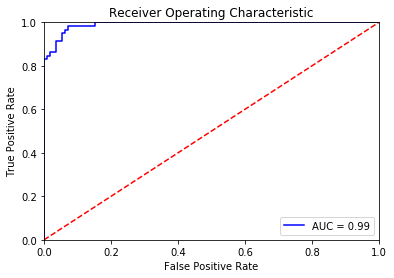

In [19]:
# Plot the AUC-ROC curve
fpr, tpr, threshold = metrics.roc_curve(results["true"], results["pred_1"])
roc_auc = metrics.auc(fpr, tpr)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## Closing

In this notebook we used SageMaker script mode to build, train, and deploy a sklearn model.